In [1]:
!kaggle datasets download -d pkdarabi/diagnosis-of-diabetic-retinopathy

Dataset URL: https://www.kaggle.com/datasets/pkdarabi/diagnosis-of-diabetic-retinopathy
License(s): Attribution 4.0 International (CC BY 4.0)
 47% 14.0M/30.1M [00:00<00:00, 144MB/s]
100% 30.1M/30.1M [00:00<00:00, 200MB/s]


In [2]:
import zipfile
zip_ref = zipfile.ZipFile('/content/diagnosis-of-diabetic-retinopathy.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [3]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import sklearn
import tensorflow as tf
from tensorflow import keras
from PIL import Image as im
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout,MaxPooling2D,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from pathlib import Path
from tqdm.notebook import tqdm
from sklearn import preprocessing
import plotly.express as px
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

In [4]:
train_root_path ='/content/Diagnosis of Diabetic Retinopathy/train'
test_root_path ='/content/Diagnosis of Diabetic Retinopathy/test'
validation_path='/content/Diagnosis of Diabetic Retinopathy/valid'

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
shear_range = 0.2,
zoom_range = 0.2,
horizontal_flip = True,
rescale=1./255
)

test_datagen = ImageDataGenerator(rescale = 1./255)


In [6]:
train_set = train_datagen.flow_from_directory(
    '/content/Diagnosis of Diabetic Retinopathy/train',
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

Found 2076 images belonging to 2 classes.


In [7]:
validation_set = test_datagen.flow_from_directory(
    '/content/Diagnosis of Diabetic Retinopathy/valid',
    target_size=(224,224),
    color_mode="rgb",
    batch_size=32,  # set as validation data
    class_mode='categorical',
    shuffle=True
)

Found 531 images belonging to 2 classes.


In [8]:
test_set = test_datagen.flow_from_directory(
    '/content/Diagnosis of Diabetic Retinopathy/test',
    target_size=(224,224),
    color_mode="rgb",
    batch_size=32,  # set as test data
    class_mode='categorical',
    shuffle=True
)

Found 231 images belonging to 2 classes.


In [9]:
#Check data type/shape
img= train_set[0]
print(f'Train data type: {type(train_set)}')
print(f'Train data shape: {train_set[0][0].shape}')
print(f'Train classes: {img[1].shape}')

img= validation_set[0]
print(f'\nValid. data type: {type(validation_set)}')
print(f'Valid. data shape: {validation_set[0][0].shape}')
print(f'Valid. classes: {img[1].shape}')

img= test_set[0]
print(f'\nTest data type: {type(test_set)}')
print(f'Test data shape: {test_set[0][0].shape}')
print(f'Test classes: {img[1].shape}')

Train data type: <class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>
Train data shape: (32, 224, 224, 3)
Train classes: (32, 2)

Valid. data type: <class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>
Valid. data shape: (32, 224, 224, 3)
Valid. classes: (32, 2)

Test data type: <class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>
Test data shape: (32, 224, 224, 3)
Test classes: (32, 2)


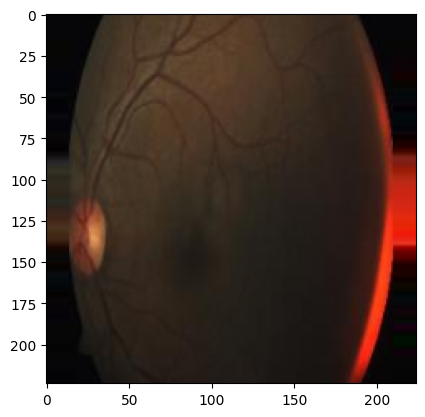

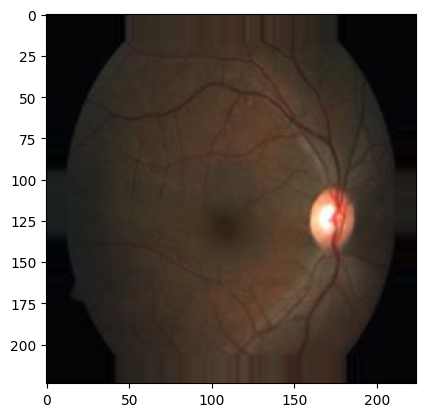

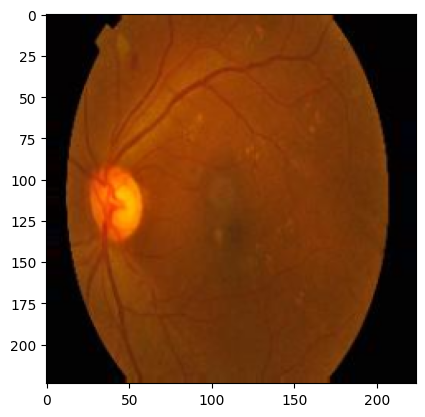

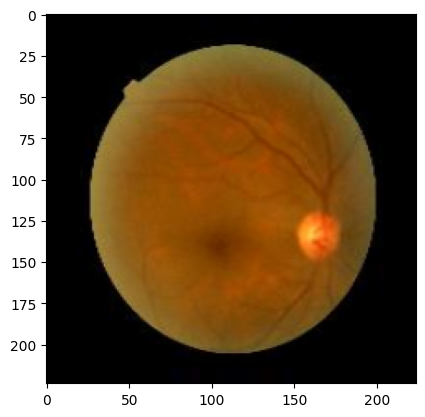

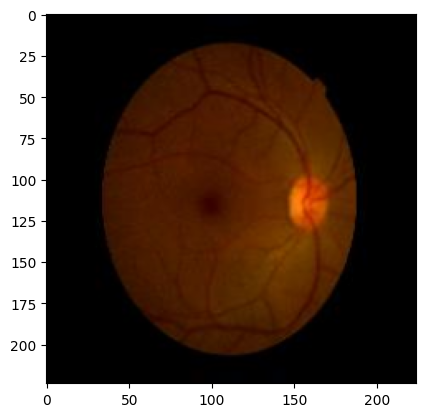

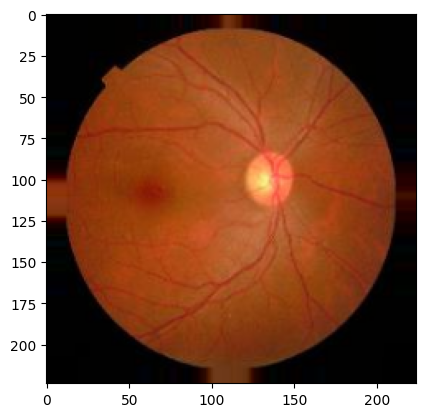

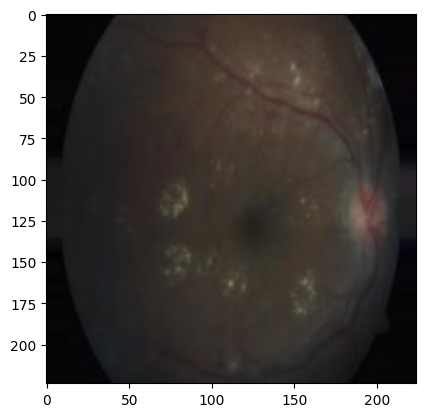

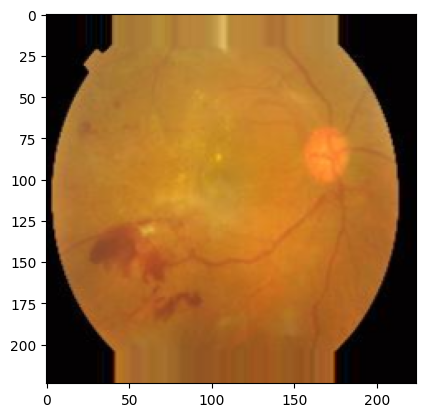

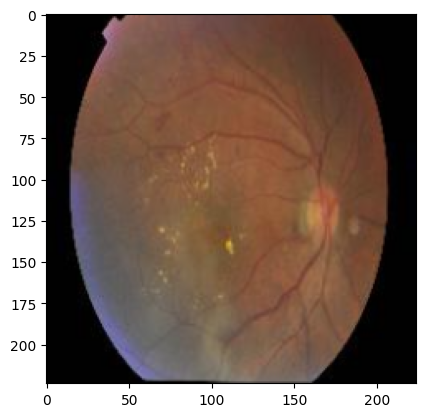

In [10]:
im, la = next(train_set)

for i in range(9):
    plt.imshow(im[i])
    plt.show()

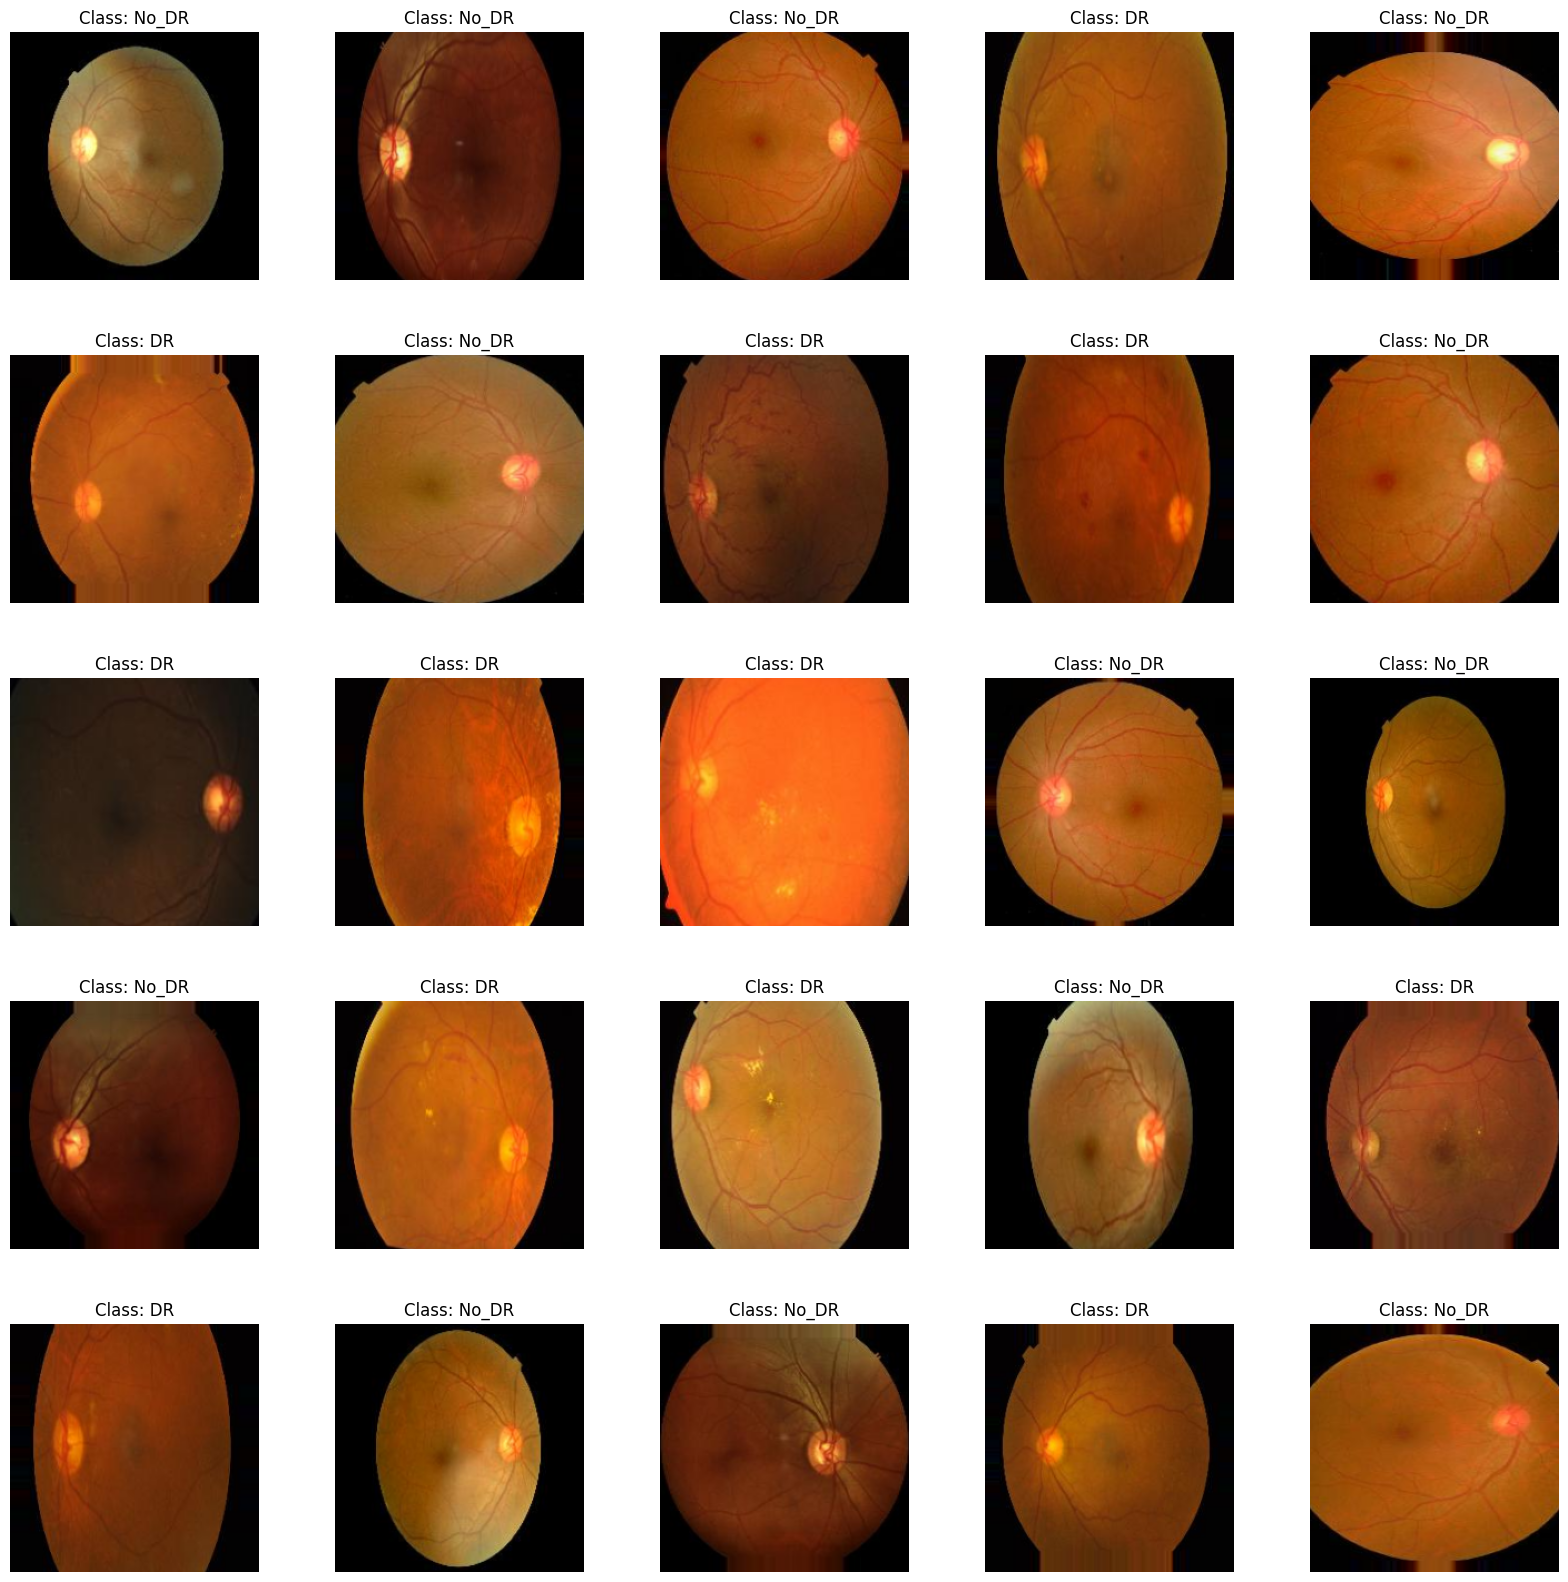

In [11]:
# Display a grid of 25 sample training images with corresponding class labels.
labels = [k for k in train_set.class_indices]
sample_generate = train_set.__next__()

images = sample_generate[0]
titles = sample_generate[1]
plt.figure(figsize = (20 , 20))

for i in range(25):
    plt.subplot(5 , 5, i+1)
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
    plt.imshow(images[i])
    plt.title(f'Class: {labels[np.argmax(titles[i],axis=0)]}')
    plt.axis("off")

Working with 1026 images
Image examples: 
495106ae3b68_png.rf.f405ceabf01366e4d5d59df72774cd56.jpg


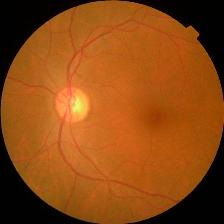

7ccf9d25dc48_png.rf.6875cf9eb2b71d97545b15dd44947cc7.jpg


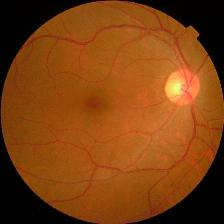

4276b82e4489_png.rf.c24b41a680672b9b1ae25b60d0bfc1da.jpg


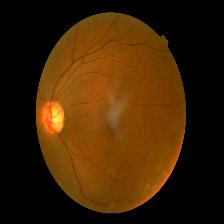

33d72035c27a_png.rf.aa0f70297ea6eeb4dfcfac0d09f93bdd.jpg


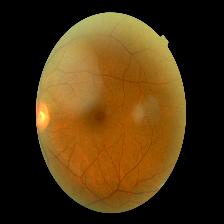

fce73678f650_png.rf.ae36a57449ba6e86ae0682e0de773373.jpg


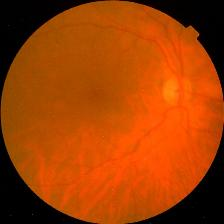

6c9c902a97de_png.rf.91d85d3f8d2b44c41a0f2cec18e4d1ed.jpg


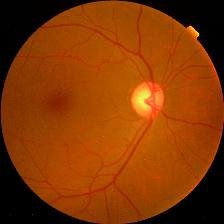

d6df4fe492ec_png.rf.ab7f76e04bff7ebd5d65150ef4c2e0bc.jpg


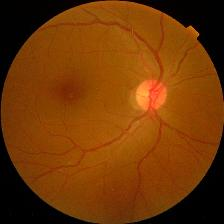

9f1b14dfa14c_png.rf.11c0378d648cfaa371bb6b17930f3cda.jpg


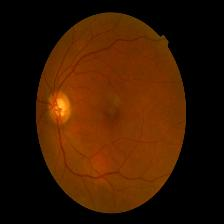

ef476be214d4_png.rf.b95b6ca70066ac07df02c7cf2a605b6a.jpg


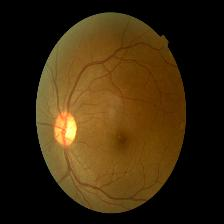

a0445785e2f7_png.rf.30f452984711b0321336f74e9c6afbd0.jpg


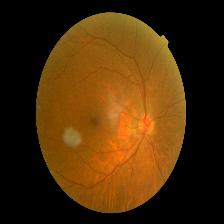

In [12]:
from PIL import Image
import os
from IPython.display import display
from IPython.display import Image as _Imgdis
# creating a object

image_path = "/content/Diagnosis of Diabetic Retinopathy/train"
folder = image_path+'/No_DR'



onlybenignfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
print("Working with {0} images".format(len(onlybenignfiles)))
print("Image examples: ")


for i in range(10):
    print(onlybenignfiles[i])
    display(_Imgdis(filename=folder + "/" + onlybenignfiles[i], width=240, height=240))

In [14]:
BATCH_SIZE = 32
IMAGE_SIZE = [224, 224]
CHANNELS=3
EPOCHS=25

In [15]:
ResNet50 = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:

for layer in ResNet50.layers:
    print(layer)

<InputLayer name=input_layer, built=True>
<ZeroPadding2D name=conv1_pad, built=True>
<Conv2D name=conv1_conv, built=True>
<BatchNormalization name=conv1_bn, built=True>
<Activation name=conv1_relu, built=True>
<ZeroPadding2D name=pool1_pad, built=True>
<MaxPooling2D name=pool1_pool, built=True>
<Conv2D name=conv2_block1_1_conv, built=True>
<BatchNormalization name=conv2_block1_1_bn, built=True>
<Activation name=conv2_block1_1_relu, built=True>
<Conv2D name=conv2_block1_2_conv, built=True>
<BatchNormalization name=conv2_block1_2_bn, built=True>
<Activation name=conv2_block1_2_relu, built=True>
<Conv2D name=conv2_block1_0_conv, built=True>
<Conv2D name=conv2_block1_3_conv, built=True>
<BatchNormalization name=conv2_block1_0_bn, built=True>
<BatchNormalization name=conv2_block1_3_bn, built=True>
<Add name=conv2_block1_add, built=True>
<Activation name=conv2_block1_out, built=True>
<Conv2D name=conv2_block2_1_conv, built=True>
<BatchNormalization name=conv2_block2_1_bn, built=True>
<Activa

In [17]:
for layer in ResNet50.layers:
    layer.trainable = False

In [18]:
ResNet50.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [19]:
model_ResNet50 = Sequential()

model_ResNet50.add(ResNet50)
model_ResNet50.add(Flatten())
model_ResNet50.add(Dropout(0.2))
model_ResNet50.add(Dense(256,activation='relu'))
model_ResNet50.add(Dropout(0.2))
model_ResNet50.add(Dense(2,activation='softmax'))
model_ResNet50.build(input_shape=(None,224,224,3))

In [20]:
model_ResNet50.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      25,690,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,278,594 (187.98 MB)

 Trainable params: 25,690,882 (98.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [21]:
model_ResNet50.compile(
    optimizer = 'Adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
  )

In [22]:
model_vgg_history = model_ResNet50.fit(
  train_set,
  validation_data=validation_set,
  epochs=EPOCHS,

)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


65/65 ━━━━━━━━━━━━━━━━━━━━ 52s 561ms/step - accuracy: 0.5484 - loss: 5.6702 - val_accuracy: 0.5405 - val_loss: 1.0129
Epoch 2/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 63s 381ms/step - accuracy: 0.5897 - loss: 0.7440 - val_accuracy: 0.6968 - val_loss: 0.5544
Epoch 3/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 26s 363ms/step - accuracy: 0.6592 - loss: 0.5963 - val_accuracy: 0.7119 - val_loss: 0.5049
Epoch 4/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 27s 376ms/step - accuracy: 0.6500 - loss: 0.6376 - val_accuracy: 0.8663 - val_loss: 0.5111
Epoch 5/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 26s 367ms/step - accuracy: 0.6741 - loss: 0.5961 - val_accuracy: 0.8117 - val_loss: 0.4448
Epoch 6/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 42s 381ms/step - accuracy: 0.7343 - loss: 0.5237 - val_accuracy: 0.8795 - val_loss: 0.3731
Epoch 7/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 27s 384ms/step - accuracy: 0.7235 - loss: 0.5205 - val_accuracy: 0.7552 - val_loss: 0.4499
Epoch 8/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 38s 352ms/step - accuracy: 0.7114 - loss: 0.5381 - val_accuracy: 0.862

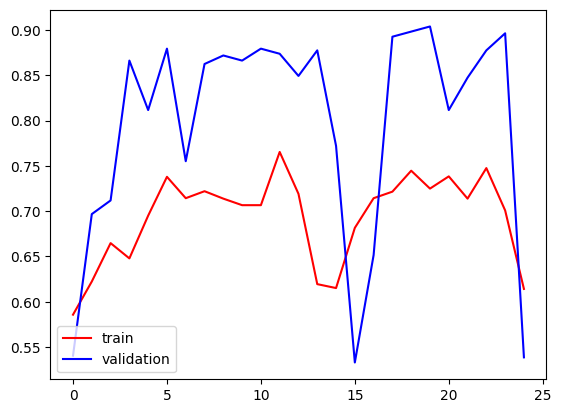

In [23]:
import matplotlib.pyplot as plt

plt.plot(model_vgg_history.history['accuracy'],color='red',label='train')
plt.plot(model_vgg_history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

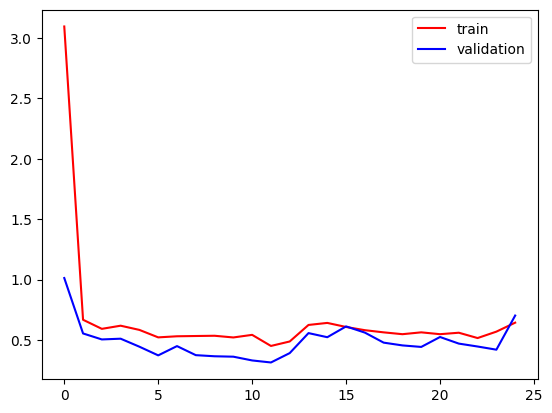

In [24]:
plt.plot(model_vgg_history.history['loss'],color='red',label='train')
plt.plot(model_vgg_history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [26]:
model_ResNet50.save('/content/B_DR_model_ResNet50.h5')
model_ResNet50.save('B_DR_model_ResNet50.keras')

In [27]:
#model evaluation on validation set
train_loss,train_accuracy = model_ResNet50.evaluate(train_set)
train_loss,train_accuracy = model_ResNet50.evaluate(validation_set)
train_loss,train_accuracy = model_ResNet50.evaluate(test_set)

65/65 ━━━━━━━━━━━━━━━━━━━━ 30s 460ms/step - accuracy: 0.5169 - loss: 0.7201
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.5379 - loss: 0.7023
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 522ms/step - accuracy: 0.5330 - loss: 0.7080


In [28]:
B_DR_model_ResNet50 = model_vgg_history.history
B_DR_model_ResNet50

{'accuracy': [0.5857418179512024,
  0.6223506927490234,
  0.6647399067878723,
  0.6478805541992188,
  0.6950867176055908,
  0.7379575967788696,
  0.7143545150756836,
  0.7220616340637207,
  0.7138728499412537,
  0.7066473960876465,
  0.7066473960876465,
  0.7654142379760742,
  0.7191714644432068,
  0.6194605231285095,
  0.6151252388954163,
  0.6815991997718811,
  0.7143545150756836,
  0.7215799689292908,
  0.7447013258934021,
  0.7249518036842346,
  0.7384393215179443,
  0.7138728499412537,
  0.747591495513916,
  0.7008670568466187,
  0.6141618490219116],
 'loss': [3.0935215950012207,
  0.6676203012466431,
  0.5925300121307373,
  0.6185994744300842,
  0.5837402939796448,
  0.5220072269439697,
  0.5310928225517273,
  0.5332965850830078,
  0.5353538393974304,
  0.5213477611541748,
  0.5427926778793335,
  0.4510957896709442,
  0.4880802631378174,
  0.6248146891593933,
  0.6415870785713196,
  0.6080154776573181,
  0.5814265608787537,
  0.5634955763816833,
  0.5483146905899048,
  0.56360763

In [29]:
#recording history in json
import json
with open('/content/B_DR_model_ResNet50.json', 'w') as f:
    json.dump(model_vgg_history.history, f)

In [ ]:
# loaded_model = load_model('/content/model.h5')

In [30]:
# Evaluate the model
y_pred = model_ResNet50.predict(test_set)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_set.classes

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 483ms/step


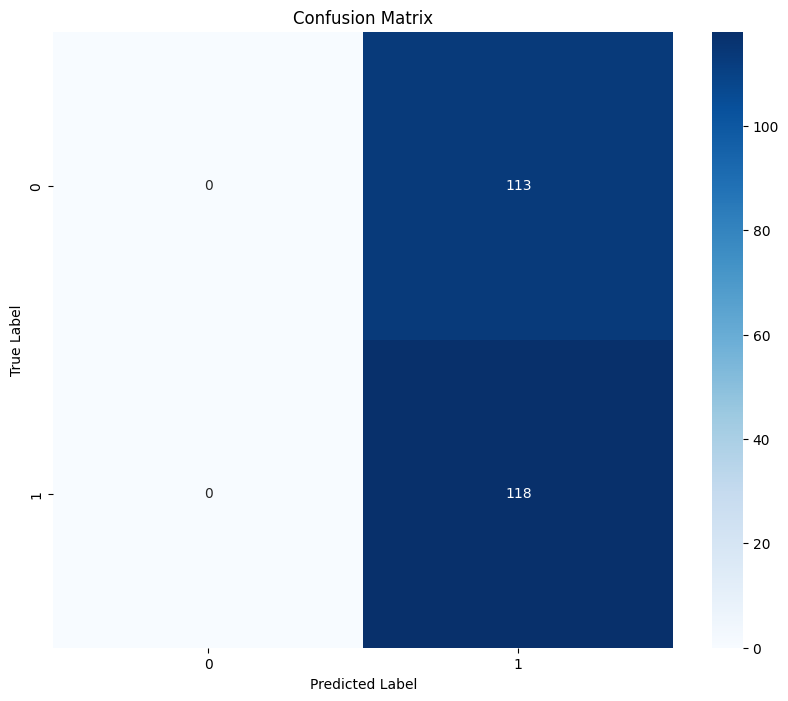

In [31]:

# Plot confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred_classes)
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [32]:
# Generate classification report
report = classification_report(y_true, y_pred_classes, target_names=test_set.class_indices.keys(), output_dict=True)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [33]:
# Print classification report
print("Classification Report:")
print(f"Accuracy: {report['accuracy']:.2f}")
print(f"Macro Avg Precision: {report['macro avg']['precision']:.2f}")
print(f"Macro Avg Recall: {report['macro avg']['recall']:.2f}")
print(f"Macro Avg F1-score: {report['macro avg']['f1-score']:.2f}")

Classification Report:
Accuracy: 0.51
Macro Avg Precision: 0.26
Macro Avg Recall: 0.50
Macro Avg F1-score: 0.34


In [34]:

# Plot individual class metrics
classes = list(test_set.class_indices.keys())
metrics = ['precision', 'recall', 'f1-score']

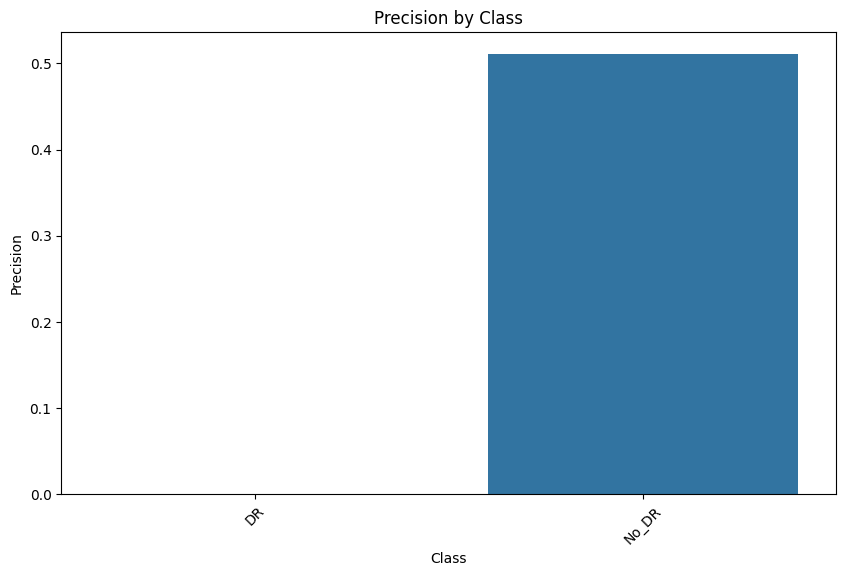

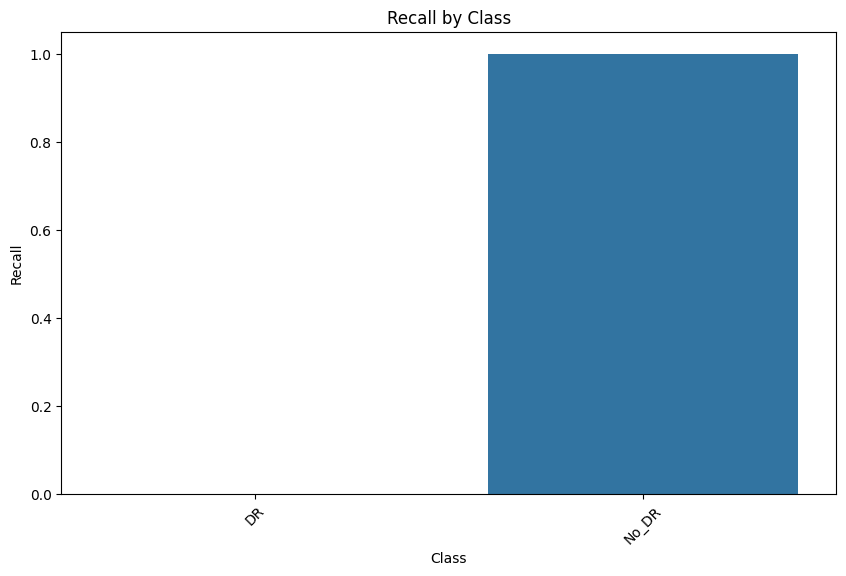

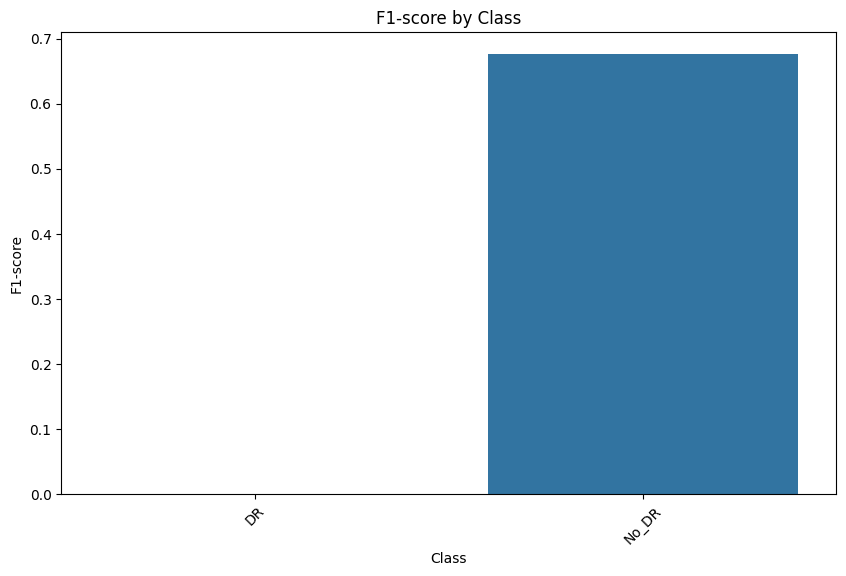

In [35]:
for metric in metrics:
    plt.figure(figsize=(10, 6))
    values = [report[cls][metric] for cls in classes]
    sns.barplot(x=classes, y=values)
    plt.title(f'{metric.capitalize()} by Class')
    plt.ylabel(metric.capitalize())
    plt.xlabel('Class')
    plt.xticks(rotation=45)
    plt.show()